In [1]:
from pyHalo.PresetModels.cdm import CDM 
import matplotlib.pyplot as plt 
import numpy as np 

## Galaxy cluster substructure

Some of the functionality built into pyHalo preset models imposes certain assumptions that are appropriate for massive elliptical galaxy deflectors, but not necessarily galaxy cluster environments. There assumptions are mainly related to tidal stripping of subhalos, and how the projected number of subhalos scales with the host halo mass and redshift. 

This notebook shows how to use the preset models in pyHalo without imposing these assumptions. In particular: 
- the keyword argument log10_dNdA specifies the amplitude of the cluster subhalo mass function directly in terms of the number of objects per square kpc (this omits automatic scalings with host halo mass and redshift calibrated for massive ellipticals)
- the use of a new tidal stripping model TruncationBoundMassPDF allows one to use the functionality in pyHalo to get subhalo density profiles from tidal tracks, but allows the user to specify the distribution of bound masses, rather than calculating the bound masses using a tidal stripping model calibrated for galaxies

\begin{equation}
\frac{d^2N}{dm dA} = \frac{\Sigma}{m_0}\left(\frac{m}{m_0}\right)^{-\alpha}
\end{equation}

\begin{equation}
\Sigma = 10^{\log_{10} dNdA} \ ; \ m_0 = 10^{8} M_{\odot}
\end{equation}

(array([8.410e+02, 1.802e+03, 2.641e+03, 2.664e+03, 1.871e+03, 9.820e+02,
        3.360e+02, 6.800e+01, 1.700e+01, 1.000e+00]),
 array([ 0.40461956,  1.46560536,  2.52659115,  3.58757695,  4.64856275,
         5.70954854,  6.77053434,  7.83152014,  8.89250594,  9.95349173,
        11.01447753]),
 <BarContainer object of 10 artists>)

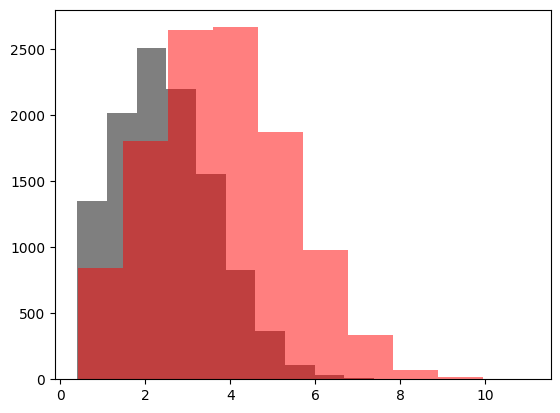

In [5]:
z_cluster = 0.4 # cluster redshift
z_source = 0.9 # source redshift 
log10_dNdA = -1.0 # the amplitude of the projected SHMF without any automatically scaling with halo mass/redshift
log_m_host = 14.0 # apppropriate for cluster, also will increase the number of subhalos introduced through two-halo term
opening_angle_arcsec = 8.0 

# tidal truncation class
from pyHalo.Halos.tidal_truncation import TruncationBoundMassPDF
class TruncationBoundMassPDFCustom1(TruncationBoundMassPDF):
    """
    This class uses the latest tidal stripping model by Du & Gilman et al. (2025), but skips the calculation of the bound 
    mass based on the assumption that the deflector is a massive elliptical. 
    
    Here, we can specify the distribution of subhalo bound masses directly as a Gaussian in log10(mbound / m_infall). Then, we
    can use the tidal tracks to get the density profile. 

    Just set the values of fbound mean/sigma below, for this example the assumption is that cluster subhalos are stripped to 10% 
    of their infall masses, on average, with a standard deviation of 0.5 dex in log10(m_bound / m_infall). 
    """
    log10_fbound_mean = -1.0
    log10_fbound_standard_dev = 0.5
    def __init__(self, lens_cosmo):
        super(TruncationBoundMassPDFCustom1, self).__init__(lens_cosmo, self.log10_fbound_mean, self.log10_fbound_standard_dev)
 
cluster_cdm = CDM(z_cluster, z_source, 
                  log10_dNdA=log10_dNdA, cone_opening_angle_arcsec=opening_angle_arcsec,
                  log_m_host=log_m_host, 
                 truncation_model_subhalos=TruncationBoundMassPDFCustom1,
                  infall_redshift_model='DIRECT_INFALL_CLUSTER'
                 )

In [ ]:
kappa_scale_subhalos = 10 ** -1.0  # the average subhalo bound mass is now 10^log10_fbound_mean lower, so we rescale mass sheets accoringly
kwargs_mass_sheet = {'kappa_scale_subhalos': kappa_scale_subhalos}
lens_model_list, lens_redshift_list, kwargs_halos, _ = cluster_cdm.lensing_quantities(kwargs_mass_sheet=kwargs_mass_sheet)

In [ ]:
from lenstronomy.LensModel.lens_model import LensModel

_r = np.linspace(-2, 2, 100)
_xx, _yy = np.meshgrid(_r, _r)
lens_model = LensModel(lens_model_list, lens_redshift_list=list(lens_redshift_list),
                      z_source=z_source, multi_plane=True)
kappa = lens_model.kappa(_xx.ravel(), _yy.ravel(), kwargs_halos)

plt.imshow(kappa.reshape(100, 100),vmin=-0.05, vmax=0.05, cmap='bwr')

### Subhalo properties 

Each realization is composed of a large number of Halo classes, from which we can access quantities related to the denstiy profile. In the case of NFW profiles and the tidal stripping model used above, we can look at the density normalization and scale radius (evaluated at infall), and the evolved density normalization after tidal stripping, following the model presented by Du and Gilman et al. (2025). 

In [ ]:
rhos_infall = []
rhos_evolved = []
rs_infall = []

f_t, tau = [], []
bound_mass = []
infall_mass = []

for halo in cluster_cdm.halos:
    if halo.is_subhalo:
        _rhos_infall, _rs_infall, _ = halo.nfw_params # units are all M_sun and kpc
        _rho_evolved = _rhos_infall * halo._rescale_norm
        rhos_infall.append(_rhos_infall)
        rhos_evolved.append(_rho_evolved)
        rs_infall.append(_rs_infall)
        f_t.append(halo.rescale_norm) # this is an overall rescaling of the profile 
        _, r_t = halo.profile_args # this it r_t parameter, just the truncation radius
        tau.append(r_t/_rs_infall) # truncation in units of halo scale radius
        bound_mass.append(halo.bound_mass)
        infall_mass.append(halo.mass)

fig = plt.figure(1)
ax1 = plt.subplot(111)
ax1.scatter(rhos_infall, rs_infall,s=1,alpha=0.5,color='k')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.scatter(rhos_evolved, rs_infall,s=1,color='r',alpha=0.5)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\rho_s$',fontsize=20)
ax1.set_ylabel(r'$r_s$',fontsize=20)
plt.show()

fig = plt.figure(2)
sigma_crit = cluster_cdm.lens_cosmo.sigma_crit_lens_kpc # units M_sun / kpc^2
print(np.log10(sigma_crit))
kappa_sub = np.array(rhos_infall) * np.array(rs_infall) / sigma_crit
plt.hist(np.log10(kappa_sub),color='k')
plt.xlabel(r'$\log_{10} \left(\Sigma / \Sigma_{\rm{crit}}\right)$',fontsize=20)
plt.show() 

plt.figure(3)
plt.hist(f_t,range=(0.1, 1),bins=20)
plt.xlabel('f_t',fontsize=18)

plt.figure(4)
plt.hist(tau,bins=20,range=(0.1, 5))
plt.xlabel('rt / rs',fontsize=18)

plt.figure(5)
ax = plt.subplot(111)
f_bound = np.array(bound_mass)/np.array(infall_mass)
f_t = np.array(f_t)
ax.scatter(f_bound, f_t)
ax.set_xscale('log')
ax.set_xlabel('m_bound / m_infall',fontsize=18)
ax.set_ylabel('f_t',fontsize=18)

plt.figure(6)
ax = plt.subplot(111)
f_t = np.array(f_t)
ax.scatter(f_bound, tau)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('m_bound / m_infall',fontsize=18)
ax.set_ylabel('r_t / r_s',fontsize=18)

### Self-interacting dark matter

The simplest way to use SIDM is simply to translate the CDM population into an SIDM population parameterized by the fraction of core-collapsed halos in different mass bins

In [ ]:
from pyHalo.realization_extensions import RealizationExtensions

ext = RealizationExtensions(cluster_cdm)
collapsed_halo_profile='TNFWC'
x_core_halo = 0.05
kwargs_collapsed_profile={'x_core_halo': x_core_halo}
mass_ranges_subhalos = [[6, 8], [8, 10]] # mass ranges in log10 M; for subhalos we refer to infall mass
mass_ranges_fieldhalos = mass_ranges_subhalos
collapse_fraction_subhalos = [0.8, 0.5] # the fraction of collapsed subhalos in each bin
collapse_fraction_fieldhalos = [0.5, 0.1] # the fraction of collapsed field halos in each bin
index_core_collapsed = ext.core_collapse_by_mass(mass_ranges_subhalos, mass_ranges_fieldhalos,
                              collapse_fraction_subhalos, collapse_fraction_fieldhalos) 
cluster_sidm = ext.add_core_collapsed_halos(index_core_collapsed, 
                                            halo_profile=collapsed_halo_profile,
                                            **kwargs_collapsed_profile)

In [ ]:
lens_model_list_sidm, lens_redshift_list_sidm, kwargs_halos_sidm, _ = cluster_sidm.lensing_quantities(kwargs_mass_sheet=kwargs_mass_sheet)
lens_model_sidm = LensModel(lens_model_list_sidm, lens_redshift_list=list(lens_redshift_list_sidm),
                      z_source=z_source, multi_plane=True)
kappa = lens_model_sidm.kappa(_xx.ravel(), _yy.ravel(), kwargs_halos_sidm)
plt.imshow(kappa.reshape(100, 100),vmin=-0.05, vmax=0.05, cmap='bwr')

### Warm dark matter  

Use the preset model

In [ ]:
from pyHalo.PresetModels.wdm import WDM 

log10_half_mode_mass = 8.0
cluster_wdm = WDM(z_cluster, z_source, log_mc=log10_half_mode_mass,
                  log10_dNdA=log10_dNdA, cone_opening_angle_arcsec=opening_angle_arcsec,
                  log_m_host=log_m_host, 
                 truncation_model_subhalos=TruncationBoundMassPDFCustom1)

lens_model_list_wdm, lens_redshift_list_wdm, kwargs_halos_wdm, _ = cluster_wdm.lensing_quantities(kwargs_mass_sheet=kwargs_mass_sheet)
lens_model_wdm = LensModel(lens_model_list_wdm, lens_redshift_list=list(lens_redshift_list_wdm),
                      z_source=z_source, multi_plane=True)
kappa = lens_model_wdm.kappa(_xx.ravel(), _yy.ravel(), kwargs_halos_wdm)
plt.imshow(kappa.reshape(100, 100),vmin=-0.05, vmax=0.05, cmap='bwr')

### Fuzzy DM 

In [ ]:
from pyHalo.PresetModels.uldm import ULDM 
from lenstronomy.LensModel.lens_model import LensModel

log10_m_uldm = -21.5
log10_dNdA = -1.0
fluctuation_aperture = 1.0
n_cut = 600000
# center the fluctuations at (0, 0)
flucs_args = {'x_images': [0.0], 'y_images': [0.0], 'aperture': fluctuation_aperture}
cluster_uldm = ULDM(z_cluster, z_source, log10_m_uldm=log10_m_uldm,
                  log10_dNdA=log10_dNdA, cone_opening_angle_arcsec=opening_angle_arcsec,
                  log_m_host=log_m_host, flucs_args=flucs_args, mdef_halos='TNFW', # use regular TNFW profiles
                 truncation_model_subhalos=TruncationBoundMassPDFCustom1,
                   n_cut=n_cut)

kappa_scale_subhalos = 10 ** -1.0  # the average subhalo bound mass is now 10^log10_fbound_mean lower, so we rescale mass sheets accoringly
kwargs_mass_sheet = {'kappa_scale_subhalos': kappa_scale_subhalos}
lens_model_list_uldm, lens_redshift_list_uldm, kwargs_halos_uldm, _ = cluster_uldm.lensing_quantities(kwargs_mass_sheet=kwargs_mass_sheet)
lens_model_uldm = LensModel(lens_model_list_uldm, lens_redshift_list=list(lens_redshift_list_uldm),
                      z_source=z_source, multi_plane=True)

npix = 100
_r = np.linspace(-fluctuation_aperture, fluctuation_aperture, npix)
_xx, _yy = np.meshgrid(_r, _r)
kappa = lens_model_uldm.kappa(_xx.ravel(), _yy.ravel(), kwargs_halos_uldm)

In [ ]:
vmin_max = 0.25
plt.imshow(kappa.reshape(npix, npix),vmin=-vmin_max, vmax=vmin_max, cmap='bwr')

In [ ]:
lens_cosmo =  cluster_cdm.lens_cosmo 
rhos, rs, _ = lens_cosmo.NFW_params_physical(10**6, 50, 0.0)
print(np.log10(rhos*rs))